## import modules

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

---

## load data to pandas dataframe

In [2]:
path_dir = './logs'
file_list = os.listdir(path_dir)
file_list.sort()
data = pd.DataFrame()
for file in file_list:
    now = pd.read_csv(f'{path_dir}/{file}', sep='\r\s', header=None, engine='python')
    data = pd.concat([data,now])
data[['date', 'time','loglevel' ,'serviceID', 'message']] = data[0].str.split(' ', n=4, expand=True)
warnings.filterwarnings(action='ignore')
data.describe()

0        date  \
count                                                 213         213   
unique                                                213           2   
top     03/08/2020 16:13:48 [0] 30-Normal: Index conne...  03/08/2020   
freq                                                    1         206   

            time loglevel   serviceID                                 message  
count        213      213         213                                     213  
unique        49        2           2                                     138  
top     15:37:12      [1]  30-Normal:  Index connection granted to: 127.0.0.1  
freq          14      177         210                                      17

---

## assign index and datetime

In [3]:
data['datetime'] = data['date'] + data['time']
data['timestamp'] = pd.to_datetime(data['datetime'], format="%d/%m/%Y%H:%M:%S")
data.drop(columns=[0,'date','time','datetime'], inplace=True)
data.insert(0,'index', range(len(data)))
data.set_index('index',inplace=True)
data = data[['timestamp', 'serviceID', 'loglevel', 'message']]
data

timestamp   serviceID loglevel  \
index                                            
0     2020-08-03 01:37:01  30-Normal:      [1]   
1     2020-08-03 01:37:01  30-Normal:      [1]   
2     2020-08-03 01:37:01  30-Normal:      [1]   
3     2020-08-03 02:37:01  30-Normal:      [1]   
4     2020-08-03 02:37:01  30-Normal:      [1]   
...                   ...         ...      ...   
208   2020-08-04 10:54:15  30-Normal:      [1]   
209   2020-08-04 10:54:15   70-Error:      [1]   
210   2020-08-04 10:54:15  30-Normal:      [1]   
211   2020-08-04 10:56:15  30-Normal:      [1]   
212   2020-08-04 10:56:15  30-Normal:      [1]   

                                                 message  
index                                                     
0      Unstemmed flush complete. 9201 inserts, 509 up...  
1                               Done Indexing IndexID=21  
2                   Index command finished. Took 11.91 s  
3      Unstemmed flush complete. 10209 inserts, 2030 ...  
4                               Done Indexing IndexID=22  
...                                                  ...  
208    Index Queue Command: DREADD?C%3A%5CUsers%5CUSE...  
209    Indexing Error: Cannot open index file "C:\Use...  
210                  Index command finished. Took 0.01 s  
211                   Delayed sync mode: Starting commit  
212      Delayed sync mode: Finished commit. Took 0.02 s  

[213 rows x 4 columns]

---

## extract command messages and processing time

In [4]:
took = data[data['message'].str.contains('Took')]
process = data.iloc[list(took.index-1)]
process.insert(4,'processtime', list(took['message']))
process['processtime'] = process['processtime'].str.replace('[^0-9.]','')
process['processtime'] = process['processtime'].str[1:]
process['processtime'] = pd.to_numeric(process['processtime'])
process.head()

timestamp   serviceID loglevel                   message  \
index                                                                      
1     2020-08-03 01:37:01  30-Normal:      [1]  Done Indexing IndexID=21   
4     2020-08-03 02:37:01  30-Normal:      [1]  Done Indexing IndexID=22   
7     2020-08-03 03:37:01  30-Normal:      [1]  Done Indexing IndexID=23   
10    2020-08-03 04:37:01  30-Normal:      [1]  Done Indexing IndexID=24   
13    2020-08-03 05:37:01  30-Normal:      [1]  Done Indexing IndexID=25   

       processtime  
index               
1            11.91  
4            10.91  
7            12.91  
10            6.91  
13            1.91

---

## extract inserts and updates

In [93]:
idx = process[process['message'].str.contains('Done Indexing')]
idx['document'] = list(data.iloc[list(idx.index-1)].message)
idx['document'] = idx['document'].str.replace('[^\d,]','')
idx[['insert', 'update']] = idx['document'].str.split(',', n=2, expand=True)
idx['insert'] = idx['insert'].str.replace('^\s*$', '0')
idx['update'].fillna(0,inplace = True)
idx['insert'] = pd.to_numeric(idx['insert'])
idx['update'] = pd.to_numeric(idx['update'])
idx.drop(columns='document',inplace=True)
idx.head()

timestamp   serviceID loglevel                   message  \
index                                                                      
1     2020-08-03 01:37:01  30-Normal:      [1]  Done Indexing IndexID=21   
4     2020-08-03 02:37:01  30-Normal:      [1]  Done Indexing IndexID=22   
7     2020-08-03 03:37:01  30-Normal:      [1]  Done Indexing IndexID=23   
10    2020-08-03 04:37:01  30-Normal:      [1]  Done Indexing IndexID=24   
13    2020-08-03 05:37:01  30-Normal:      [1]  Done Indexing IndexID=25   

       processtime  timestamphour  insert  update  
index                                              
1            11.91              1    9201     509  
4            10.91              2   10209    2030  
7            12.91              3   12019     234  
10            6.91              4    6023    3134  
13            1.91              5    1038     167

---

## group by hour

In [6]:
idx['timestamphour'] = idx['timestamp'].dt.hour
pivot = idx.pivot_table(values=['processtime', 'insert', 'update'], index='timestamphour' ,aggfunc=np.sum)
pivot['indexpersecond(docs/s)'] = ((pivot['insert'] + pivot['update']) / pivot['processtime']).astype(int)
pivot2 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc=np.mean)
pivot3 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc=np.max)
pivot4 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc=np.min)
pivot5 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc='count')
pivot['processtimemean(s)'] = pivot2['processtime'].round(2)
pivot['processtimemax(s)'] = pivot3['processtime'].round(2)
pivot['processtimemin(s)'] = pivot4['processtime'].round(2)
pivot['count(cmds)'] = pivot5['processtime'].round(2)
new_index = ['insert','update','indexpersecond(docs/s)','processtime','processtimemean(s)','processtimemax(s)','processtimemin(s)','count(cmds)']
new_index_name = {'insert':'insertsum(docs)','update':'updatesum(docs)','processtime':'processtimesum(s)'}
pivot = pivot.reindex(new_index, axis='columns')
pivot.rename(new_index_name,axis='columns',inplace=True)
pivot

insertsum(docs)  updatesum(docs)  indexpersecond(docs/s)  \
timestamphour                                                             
1                         9201              509                     815   
2                        10209             2030                    1121   
3                        12019              234                     949   
4                         6023             3134                    1325   
5                         1038              167                     630   
6                        10852             2480                    1119   
7                        20394             3400                    1085   
8                        70682            20394                    2685   
9                        80796            49850                    2909   
10                       60292             1487                    1014   
11                       30485             1048                     770   
12                       39281             3094                    2026   
13                       30482             2847                    1454   
14                       25039             5937                    1295   
15                        1599              229                     854   
16                           0                0                       0   

               processtimesum(s)  processtimemean(s)  processtimemax(s)  \
timestamphour                                                             
1                          11.91               11.91              11.91   
2                          10.91               10.91              10.91   
3                          12.91               12.91              12.91   
4                           6.91                6.91               6.91   
5                           1.91                1.91               1.91   
6                          11.91               11.91              11.91   
7                          21.91               21.91              21.91   
8                          33.91               33.91              33.91   
9                          44.91               44.91              44.91   
10                         60.91               60.91              60.91   
11                         40.91               40.91              40.91   
12                         20.91               20.91              20.91   
13                         22.91               22.91              22.91   
14                         23.91               23.91              23.91   
15                          2.14                0.71               1.91   
16                          0.06                0.01               0.02   

               processtimemin(s)  count(cmds)  
timestamphour                                  
1                          11.91            1  
2                          10.91            1  
3                          12.91            1  
4                           6.91            1  
5                           1.91            1  
6                          11.91            1  
7                          21.91            1  
8                          33.91            1  
9                          44.91            1  
10                         60.91            1  
11                         40.91            1  
12                         20.91            1  
13                         22.91            1  
14                         23.91            1  
15                          0.05            3  
16                          0.01            5

---

## data visualization

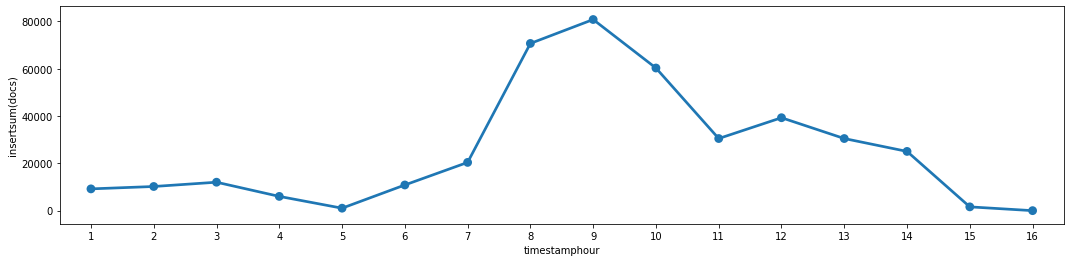

In [7]:
plt.figure(figsize=[18,4])

sns.pointplot(x=pivot.index, y='insertsum(docs)',data=pivot)

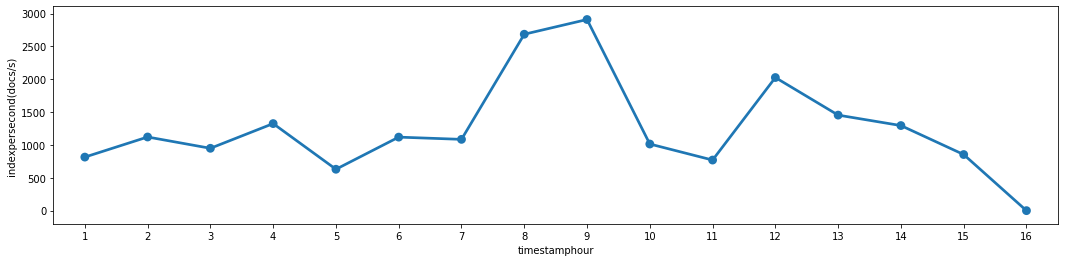

In [8]:
plt.figure(figsize=[18,4])

sns.pointplot(x=pivot.index, y='indexpersecond(docs/s)',data=pivot)

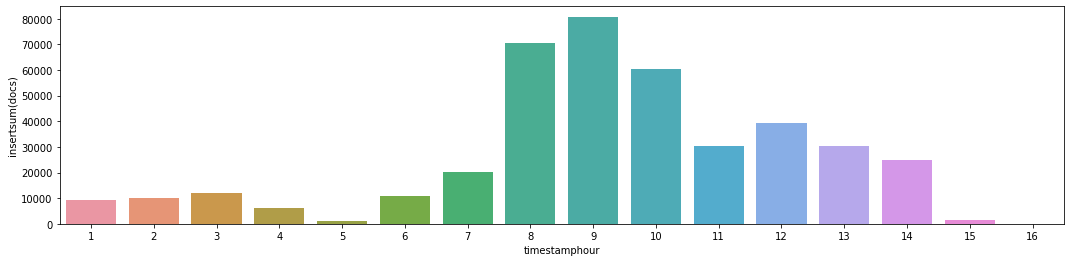

In [9]:
fig, ax4 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=pivot, x=pivot.index, y="insertsum(docs)", ax=ax4)

In [10]:
process['timestamphour'] = process['timestamp'].dt.hour
pivottable = idx.pivot_table(values='processtime', index='timestamphour' ,aggfunc=np.sum)
pivottable

processtime
timestamphour             
1                    11.91
2                    10.91
3                    12.91
4                     6.91
5                     1.91
6                    11.91
7                    21.91
8                    33.91
9                    44.91
10                   60.91
11                   40.91
12                   20.91
13                   22.91
14                   23.91
15                    2.14
16                    0.06

In [11]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter("pandas_header_format.xlsx", engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object. Note that we turn off
# the default header and skip one row to allow us to insert a user defined
# header.
pivot.to_excel(writer, sheet_name='Sheet1', startrow=1, header=False)

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Sheet1']
worksheet.set_column('A:A', 4)
worksheet.set_column('B:B', 9)
worksheet.set_column('C:C', 10)
worksheet.set_column('D:D', 14)
worksheet.set_column('E:E', 11)
worksheet.set_column('F:F', 11)
worksheet.set_column('G:G', 11)
worksheet.set_column('H:H', 11)
worksheet.set_column('I:I', 11)
worksheet.conditional_format('B2:B25', {'type': 'data_bar',
                                        'bar_color': '#5688BC'})

# Add a header format.
header_format = workbook.add_format({
    'bold': True,
    'text_wrap': True,
    'valign': 'top',
    'fg_color': '#E8F5FF',
    'border': 1})

# Write the column headers with the defined format.
for col_num, value in enumerate(pivot.columns.values):
    worksheet.write(0, col_num + 1, value, header_format)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [12]:
pivot

insertsum(docs)  updatesum(docs)  indexpersecond(docs/s)  \
timestamphour                                                             
1                         9201              509                     815   
2                        10209             2030                    1121   
3                        12019              234                     949   
4                         6023             3134                    1325   
5                         1038              167                     630   
6                        10852             2480                    1119   
7                        20394             3400                    1085   
8                        70682            20394                    2685   
9                        80796            49850                    2909   
10                       60292             1487                    1014   
11                       30485             1048                     770   
12                       39281             3094                    2026   
13                       30482             2847                    1454   
14                       25039             5937                    1295   
15                        1599              229                     854   
16                           0                0                       0   

               processtimesum(s)  processtimemean(s)  processtimemax(s)  \
timestamphour                                                             
1                          11.91               11.91              11.91   
2                          10.91               10.91              10.91   
3                          12.91               12.91              12.91   
4                           6.91                6.91               6.91   
5                           1.91                1.91               1.91   
6                          11.91               11.91              11.91   
7                          21.91               21.91              21.91   
8                          33.91               33.91              33.91   
9                          44.91               44.91              44.91   
10                         60.91               60.91              60.91   
11                         40.91               40.91              40.91   
12                         20.91               20.91              20.91   
13                         22.91               22.91              22.91   
14                         23.91               23.91              23.91   
15                          2.14                0.71               1.91   
16                          0.06                0.01               0.02   

               processtimemin(s)  count(cmds)  
timestamphour                                  
1                          11.91            1  
2                          10.91            1  
3                          12.91            1  
4                           6.91            1  
5                           1.91            1  
6                          11.91            1  
7                          21.91            1  
8                          33.91            1  
9                          44.91            1  
10                         60.91            1  
11                         40.91            1  
12                         20.91            1  
13                         22.91            1  
14                         23.91            1  
15                          0.05            3  
16                          0.01            5

In [13]:
pivot.insert(2, 'indexsum(docs)', pivot['insertsum(docs)'] + pivot['updatesum(docs)'])

In [14]:
pivot

insertsum(docs)  updatesum(docs)  indexsum(docs)  \
timestamphour                                                     
1                         9201              509            9710   
2                        10209             2030           12239   
3                        12019              234           12253   
4                         6023             3134            9157   
5                         1038              167            1205   
6                        10852             2480           13332   
7                        20394             3400           23794   
8                        70682            20394           91076   
9                        80796            49850          130646   
10                       60292             1487           61779   
11                       30485             1048           31533   
12                       39281             3094           42375   
13                       30482             2847           33329   
14                       25039             5937           30976   
15                        1599              229            1828   
16                           0                0               0   

               indexpersecond(docs/s)  processtimesum(s)  processtimemean(s)  \
timestamphour                                                                  
1                                 815              11.91               11.91   
2                                1121              10.91               10.91   
3                                 949              12.91               12.91   
4                                1325               6.91                6.91   
5                                 630               1.91                1.91   
6                                1119              11.91               11.91   
7                                1085              21.91               21.91   
8                                2685              33.91               33.91   
9                                2909              44.91               44.91   
10                               1014              60.91               60.91   
11                                770              40.91               40.91   
12                               2026              20.91               20.91   
13                               1454              22.91               22.91   
14                               1295              23.91               23.91   
15                                854               2.14                0.71   
16                                  0               0.06                0.01   

               processtimemax(s)  processtimemin(s)  count(cmds)  
timestamphour                                                     
1                          11.91              11.91            1  
2                          10.91              10.91            1  
3                          12.91              12.91            1  
4                           6.91               6.91            1  
5                           1.91               1.91            1  
6                          11.91              11.91            1  
7                          21.91              21.91            1  
8                          33.91              33.91            1  
9                          44.91              44.91            1  
10                         60.91              60.91            1  
11                         40.91              40.91            1  
12                         20.91              20.91            1  
13                         22.91              22.91            1  
14                         23.91              23.91            1  
15                          1.91               0.05            3  
16                          0.02               0.01            5

In [15]:
columns = {"insertsum(docs)":"색인 추가(회)", "updatesum(docs)":"색인 수정(회)", "indexsum(docs)":"총색인(회)","indexpersecond(docs/s)":"초당 색인 횟수(회/초)", "processtimesum(s)":"색인 시간(초)", "processtimemean(s)":"평균 색인 시간(초)", "processtimemax(s)":"최고 색인 시간(초)", "processtimemin(s)":"최저 색인 시간(초)", "count(cmds)":"색인 횟수(회)"}
pivot.rename(columns = columns, inplace = True)

In [16]:
idx

timestamp   serviceID loglevel                   message  \
index                                                                      
1     2020-08-03 01:37:01  30-Normal:      [1]  Done Indexing IndexID=21   
4     2020-08-03 02:37:01  30-Normal:      [1]  Done Indexing IndexID=22   
7     2020-08-03 03:37:01  30-Normal:      [1]  Done Indexing IndexID=23   
10    2020-08-03 04:37:01  30-Normal:      [1]  Done Indexing IndexID=24   
13    2020-08-03 05:37:01  30-Normal:      [1]  Done Indexing IndexID=25   
16    2020-08-03 06:37:01  30-Normal:      [1]  Done Indexing IndexID=26   
19    2020-08-03 07:37:01  30-Normal:      [1]  Done Indexing IndexID=27   
22    2020-08-03 08:37:01  30-Normal:      [1]  Done Indexing IndexID=28   
25    2020-08-03 09:37:01  30-Normal:      [1]  Done Indexing IndexID=29   
28    2020-08-03 10:37:01  30-Normal:      [1]  Done Indexing IndexID=30   
31    2020-08-03 11:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
34    2020-08-03 12:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
37    2020-08-03 13:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
40    2020-08-03 14:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
65    2020-08-03 15:37:01  30-Normal:      [1]   Done Indexing IndexID=5   
81    2020-08-03 15:37:12  30-Normal:      [1]   Done Indexing IndexID=6   
119   2020-08-03 15:44:46  30-Normal:      [1]   Done Indexing IndexID=9   
142   2020-08-03 16:01:27  30-Normal:      [1]  Done Indexing IndexID=11   
154   2020-08-03 16:01:34  30-Normal:      [1]  Done Indexing IndexID=12   
176   2020-08-03 16:07:43  30-Normal:      [1]  Done Indexing IndexID=15   
188   2020-08-03 16:08:01  30-Normal:      [1]  Done Indexing IndexID=16   
202   2020-08-03 16:13:48  30-Normal:      [1]  Done Indexing IndexID=17   

       processtime  insert  update  timestamphour  
index                                              
1            11.91    9201     509              1  
4            10.91   10209    2030              2  
7            12.91   12019     234              3  
10            6.91    6023    3134              4  
13            1.91    1038     167              5  
16           11.91   10852    2480              6  
19           21.91   20394    3400              7  
22           33.91   70682   20394              8  
25           44.91   80796   49850              9  
28           60.91   60292    1487             10  
31           40.91   30485    1048             11  
34           20.91   39281    3094             12  
37           22.91   30482    2847             13  
40           23.91   25039    5937             14  
65            1.91    1339      29             15  
81            0.18     214     106             15  
119           0.05      46      94             15  
142           0.02       0       0             16  
154           0.01       0       0             16  
176           0.01       0       0             16  
188           0.01       0       0             16  
202           0.01       0       0             16

In [17]:
idx['timestampdate'] = idx['timestamp'].dt.date

In [18]:
idx

timestamp   serviceID loglevel                   message  \
index                                                                      
1     2020-08-03 01:37:01  30-Normal:      [1]  Done Indexing IndexID=21   
4     2020-08-03 02:37:01  30-Normal:      [1]  Done Indexing IndexID=22   
7     2020-08-03 03:37:01  30-Normal:      [1]  Done Indexing IndexID=23   
10    2020-08-03 04:37:01  30-Normal:      [1]  Done Indexing IndexID=24   
13    2020-08-03 05:37:01  30-Normal:      [1]  Done Indexing IndexID=25   
16    2020-08-03 06:37:01  30-Normal:      [1]  Done Indexing IndexID=26   
19    2020-08-03 07:37:01  30-Normal:      [1]  Done Indexing IndexID=27   
22    2020-08-03 08:37:01  30-Normal:      [1]  Done Indexing IndexID=28   
25    2020-08-03 09:37:01  30-Normal:      [1]  Done Indexing IndexID=29   
28    2020-08-03 10:37:01  30-Normal:      [1]  Done Indexing IndexID=30   
31    2020-08-03 11:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
34    2020-08-03 12:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
37    2020-08-03 13:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
40    2020-08-03 14:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
65    2020-08-03 15:37:01  30-Normal:      [1]   Done Indexing IndexID=5   
81    2020-08-03 15:37:12  30-Normal:      [1]   Done Indexing IndexID=6   
119   2020-08-03 15:44:46  30-Normal:      [1]   Done Indexing IndexID=9   
142   2020-08-03 16:01:27  30-Normal:      [1]  Done Indexing IndexID=11   
154   2020-08-03 16:01:34  30-Normal:      [1]  Done Indexing IndexID=12   
176   2020-08-03 16:07:43  30-Normal:      [1]  Done Indexing IndexID=15   
188   2020-08-03 16:08:01  30-Normal:      [1]  Done Indexing IndexID=16   
202   2020-08-03 16:13:48  30-Normal:      [1]  Done Indexing IndexID=17   

       processtime  insert  update  timestamphour timestampdate  
index                                                            
1            11.91    9201     509              1    2020-08-03  
4            10.91   10209    2030              2    2020-08-03  
7            12.91   12019     234              3    2020-08-03  
10            6.91    6023    3134              4    2020-08-03  
13            1.91    1038     167              5    2020-08-03  
16           11.91   10852    2480              6    2020-08-03  
19           21.91   20394    3400              7    2020-08-03  
22           33.91   70682   20394              8    2020-08-03  
25           44.91   80796   49850              9    2020-08-03  
28           60.91   60292    1487             10    2020-08-03  
31           40.91   30485    1048             11    2020-08-03  
34           20.91   39281    3094             12    2020-08-03  
37           22.91   30482    2847             13    2020-08-03  
40           23.91   25039    5937             14    2020-08-03  
65            1.91    1339      29             15    2020-08-03  
81            0.18     214     106             15    2020-08-03  
119           0.05      46      94             15    2020-08-03  
142           0.02       0       0             16    2020-08-03  
154           0.01       0       0             16    2020-08-03  
176           0.01       0       0             16    2020-08-03  
188           0.01       0       0             16    2020-08-03  
202           0.01       0       0             16    2020-08-03

In [19]:
pivot = idx.pivot_table(values=['processtime', 'insert', 'update'], index=['timestampdate', 'timestamphour'] ,aggfunc=np.sum)
pivot['indexpersecond(docs/s)'] = ((pivot['insert'] + pivot['update']) / pivot['processtime']).astype(int)
pivot2 = idx.pivot_table(values='processtime', index=['timestampdate', 'timestamphour'], aggfunc=np.mean)
pivot3 = idx.pivot_table(values='processtime', index=['timestampdate', 'timestamphour'], aggfunc=np.max)
pivot4 = idx.pivot_table(values='processtime', index=['timestampdate', 'timestamphour'], aggfunc=np.min)
pivot5 = idx.pivot_table(values='processtime', index=['timestampdate', 'timestamphour'], aggfunc='count')
pivot['processtimemean(s)'] = pivot2['processtime'].round(2)
pivot['processtimemax(s)'] = pivot3['processtime'].round(2)
pivot['processtimemin(s)'] = pivot4['processtime'].round(2)
pivot['count(cmds)'] = pivot5['processtime'].round(2)
new_index = ['insert','update','indexpersecond(docs/s)','processtime','processtimemean(s)','processtimemax(s)','processtimemin(s)','count(cmds)']
new_index_name = {'insert':'insertsum(docs)','update':'updatesum(docs)','processtime':'processtimesum(s)'}
pivot = pivot.reindex(new_index, axis='columns')
pivot.rename(new_index_name,axis='columns',inplace=True)
pivot

insertsum(docs)  updatesum(docs)  \
timestampdate timestamphour                                     
2020-08-03    1                         9201              509   
              2                        10209             2030   
              3                        12019              234   
              4                         6023             3134   
              5                         1038              167   
              6                        10852             2480   
              7                        20394             3400   
              8                        70682            20394   
              9                        80796            49850   
              10                       60292             1487   
              11                       30485             1048   
              12                       39281             3094   
              13                       30482             2847   
              14                       25039             5937   
              15                        1599              229   
              16                           0                0   

                             indexpersecond(docs/s)  processtimesum(s)  \
timestampdate timestamphour                                              
2020-08-03    1                                 815              11.91   
              2                                1121              10.91   
              3                                 949              12.91   
              4                                1325               6.91   
              5                                 630               1.91   
              6                                1119              11.91   
              7                                1085              21.91   
              8                                2685              33.91   
              9                                2909              44.91   
              10                               1014              60.91   
              11                                770              40.91   
              12                               2026              20.91   
              13                               1454              22.91   
              14                               1295              23.91   
              15                                854               2.14   
              16                                  0               0.06   

                             processtimemean(s)  processtimemax(s)  \
timestampdate timestamphour                                          
2020-08-03    1                           11.91              11.91   
              2                           10.91              10.91   
              3                           12.91              12.91   
              4                            6.91               6.91   
              5                            1.91               1.91   
              6                           11.91              11.91   
              7                           21.91              21.91   
              8                           33.91              33.91   
              9                           44.91              44.91   
              10                          60.91              60.91   
              11                          40.91              40.91   
              12                          20.91              20.91   
              13                          22.91              22.91   
              14                          23.91              23.91   
              15                           0.71               1.91   
              16                           0.01               0.02   

                             processtimemin(s)  count(cmds)  
timestampdate timestamphour                                  
2020-08-03    1                          11.91            1  
              2                          10.91            1  
              3 

In [63]:
idx

timestamp   serviceID loglevel                   message  \
index                                                                      
1     2020-08-03 01:37:01  30-Normal:      [1]  Done Indexing IndexID=21   
4     2020-08-03 02:37:01  30-Normal:      [1]  Done Indexing IndexID=22   
7     2020-08-03 03:37:01  30-Normal:      [1]  Done Indexing IndexID=23   
10    2020-08-03 04:37:01  30-Normal:      [1]  Done Indexing IndexID=24   
13    2020-08-03 05:37:01  30-Normal:      [1]  Done Indexing IndexID=25   
16    2020-08-03 06:37:01  30-Normal:      [1]  Done Indexing IndexID=26   
19    2020-08-03 07:37:01  30-Normal:      [1]  Done Indexing IndexID=27   
22    2020-08-03 08:37:01  30-Normal:      [1]  Done Indexing IndexID=28   
25    2020-08-03 09:37:01  30-Normal:      [1]  Done Indexing IndexID=29   
28    2020-08-03 10:37:01  30-Normal:      [1]  Done Indexing IndexID=30   
31    2020-08-03 11:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
34    2020-08-03 12:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
37    2020-08-03 13:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
40    2020-08-03 14:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
65    2020-08-03 15:37:01  30-Normal:      [1]   Done Indexing IndexID=5   
81    2020-08-03 15:37:12  30-Normal:      [1]   Done Indexing IndexID=6   
119   2020-08-03 15:44:46  30-Normal:      [1]   Done Indexing IndexID=9   
142   2020-08-03 16:01:27  30-Normal:      [1]  Done Indexing IndexID=11   
154   2020-08-03 16:01:34  30-Normal:      [1]  Done Indexing IndexID=12   
176   2020-08-03 16:07:43  30-Normal:      [1]  Done Indexing IndexID=15   
188   2020-08-03 16:08:01  30-Normal:      [1]  Done Indexing IndexID=16   
202   2020-08-03 16:13:48  30-Normal:      [1]  Done Indexing IndexID=17   

       processtime  insert  update  timestamphour timestampdate  
index                                                            
1            11.91    9201     509              1    2020-08-03  
4            10.91   10209    2030              2    2020-08-03  
7            12.91   12019     234              3    2020-08-03  
10            6.91    6023    3134              4    2020-08-03  
13            1.91    1038     167              5    2020-08-03  
16           11.91   10852    2480              6    2020-08-03  
19           21.91   20394    3400              7    2020-08-03  
22           33.91   70682   20394              8    2020-08-03  
25           44.91   80796   49850              9    2020-08-03  
28           60.91   60292    1487             10    2020-08-03  
31           40.91   30485    1048             11    2020-08-03  
34           20.91   39281    3094             12    2020-08-03  
37           22.91   30482    2847             13    2020-08-03  
40           23.91   25039    5937             14    2020-08-03  
65            1.91    1339      29             15    2020-08-03  
81            0.18     214     106             15    2020-08-03  
119           0.05      46      94             15    2020-08-03  
142           0.02       0       0             16    2020-08-03  
154           0.01       0       0             16    2020-08-03  
176           0.01       0       0             16    2020-08-03  
188           0.01       0       0             16    2020-08-03  
202           0.01       0       0             16    2020-08-03

In [94]:
for i in range(24):
    if i < 10:
        idx.replace({'timestamphour':{i:f"0{i}:00 ~ 0{i}:59"}},inplace=True)
    else:
        idx.replace({'timestamphour':{i:f"{i}:00 ~ {i}:59"}},inplace=True)
idx

timestamp   serviceID loglevel                   message  \
index                                                                      
1     2020-08-03 01:37:01  30-Normal:      [1]  Done Indexing IndexID=21   
4     2020-08-03 02:37:01  30-Normal:      [1]  Done Indexing IndexID=22   
7     2020-08-03 03:37:01  30-Normal:      [1]  Done Indexing IndexID=23   
10    2020-08-03 04:37:01  30-Normal:      [1]  Done Indexing IndexID=24   
13    2020-08-03 05:37:01  30-Normal:      [1]  Done Indexing IndexID=25   
16    2020-08-03 06:37:01  30-Normal:      [1]  Done Indexing IndexID=26   
19    2020-08-03 07:37:01  30-Normal:      [1]  Done Indexing IndexID=27   
22    2020-08-03 08:37:01  30-Normal:      [1]  Done Indexing IndexID=28   
25    2020-08-03 09:37:01  30-Normal:      [1]  Done Indexing IndexID=29   
28    2020-08-03 10:37:01  30-Normal:      [1]  Done Indexing IndexID=30   
31    2020-08-03 11:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
34    2020-08-03 12:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
37    2020-08-03 13:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
40    2020-08-03 14:37:01  30-Normal:      [1]  Done Indexing IndexID=31   
65    2020-08-03 15:37:01  30-Normal:      [1]   Done Indexing IndexID=5   
81    2020-08-03 15:37:12  30-Normal:      [1]   Done Indexing IndexID=6   
119   2020-08-03 15:44:46  30-Normal:      [1]   Done Indexing IndexID=9   
142   2020-08-03 16:01:27  30-Normal:      [1]  Done Indexing IndexID=11   
154   2020-08-03 16:01:34  30-Normal:      [1]  Done Indexing IndexID=12   
176   2020-08-03 16:07:43  30-Normal:      [1]  Done Indexing IndexID=15   
188   2020-08-03 16:08:01  30-Normal:      [1]  Done Indexing IndexID=16   
202   2020-08-03 16:13:48  30-Normal:      [1]  Done Indexing IndexID=17   

       processtime  timestamphour  insert  update  
index                                              
1            11.91  01:00 ~ 01:59    9201     509  
4            10.91  02:00 ~ 02:59   10209    2030  
7            12.91  03:00 ~ 03:59   12019     234  
10            6.91  04:00 ~ 04:59    6023    3134  
13            1.91  05:00 ~ 05:59    1038     167  
16           11.91  06:00 ~ 06:59   10852    2480  
19           21.91  07:00 ~ 07:59   20394    3400  
22           33.91  08:00 ~ 08:59   70682   20394  
25           44.91  09:00 ~ 09:59   80796   49850  
28           60.91  10:00 ~ 10:59   60292    1487  
31           40.91  11:00 ~ 11:59   30485    1048  
34           20.91  12:00 ~ 12:59   39281    3094  
37           22.91  13:00 ~ 13:59   30482    2847  
40           23.91  14:00 ~ 14:59   25039    5937  
65            1.91  15:00 ~ 15:59    1339      29  
81            0.18  15:00 ~ 15:59     214     106  
119           0.05  15:00 ~ 15:59      46      94  
142           0.02  16:00 ~ 16:59       0       0  
154           0.01  16:00 ~ 16:59       0       0  
176           0.01  16:00 ~ 16:59       0       0  
188           0.01  16:00 ~ 16:59       0       0  
202           0.01  16:00 ~ 16:59       0       0

In [95]:
idx['timestampdate'] = idx['timestamp'].dt.date

In [96]:
pivot = idx.pivot_table(values=['processtime', 'insert', 'update'], index=['timestampdate', 'timestamphour'] ,aggfunc=np.sum)
pivot['indexpersecond(docs/s)'] = ((pivot['insert'] + pivot['update']) / pivot['processtime']).astype(int)
pivot2 = idx.pivot_table(values='processtime', index=['timestampdate', 'timestamphour'], aggfunc=np.mean)
pivot3 = idx.pivot_table(values='processtime', index=['timestampdate', 'timestamphour'], aggfunc=np.max)
pivot4 = idx.pivot_table(values='processtime', index=['timestampdate', 'timestamphour'], aggfunc=np.min)
pivot5 = idx.pivot_table(values='processtime', index=['timestampdate', 'timestamphour'], aggfunc='count')
pivot['processtimemean(s)'] = pivot2['processtime'].round(2)
pivot['processtimemax(s)'] = pivot3['processtime'].round(2)
pivot['processtimemin(s)'] = pivot4['processtime'].round(2)
pivot['count(cmds)'] = pivot5['processtime'].round(2)
new_index = ['insert','update','indexpersecond(docs/s)','processtime','processtimemean(s)','processtimemax(s)','processtimemin(s)','count(cmds)']
new_index_name = {'insert':'insertsum(docs)','update':'updatesum(docs)','processtime':'processtimesum(s)'}
pivot = pivot.reindex(new_index, axis='columns')
pivot.rename(new_index_name,axis='columns',inplace=True)
pivot

insertsum(docs)  updatesum(docs)  \
timestampdate timestamphour                                     
2020-08-03    01:00 ~ 01:59             9201              509   
              02:00 ~ 02:59            10209             2030   
              03:00 ~ 03:59            12019              234   
              04:00 ~ 04:59             6023             3134   
              05:00 ~ 05:59             1038              167   
              06:00 ~ 06:59            10852             2480   
              07:00 ~ 07:59            20394             3400   
              08:00 ~ 08:59            70682            20394   
              09:00 ~ 09:59            80796            49850   
              10:00 ~ 10:59            60292             1487   
              11:00 ~ 11:59            30485             1048   
              12:00 ~ 12:59            39281             3094   
              13:00 ~ 13:59            30482             2847   
              14:00 ~ 14:59            25039             5937   
              15:00 ~ 15:59             1599              229   
              16:00 ~ 16:59                0                0   

                             indexpersecond(docs/s)  processtimesum(s)  \
timestampdate timestamphour                                              
2020-08-03    01:00 ~ 01:59                     815              11.91   
              02:00 ~ 02:59                    1121              10.91   
              03:00 ~ 03:59                     949              12.91   
              04:00 ~ 04:59                    1325               6.91   
              05:00 ~ 05:59                     630               1.91   
              06:00 ~ 06:59                    1119              11.91   
              07:00 ~ 07:59                    1085              21.91   
              08:00 ~ 08:59                    2685              33.91   
              09:00 ~ 09:59                    2909              44.91   
              10:00 ~ 10:59                    1014              60.91   
              11:00 ~ 11:59                     770              40.91   
              12:00 ~ 12:59                    2026              20.91   
              13:00 ~ 13:59                    1454              22.91   
              14:00 ~ 14:59                    1295              23.91   
              15:00 ~ 15:59                     854               2.14   
              16:00 ~ 16:59                       0               0.06   

                             processtimemean(s)  processtimemax(s)  \
timestampdate timestamphour                                          
2020-08-03    01:00 ~ 01:59               11.91              11.91   
              02:00 ~ 02:59               10.91              10.91   
              03:00 ~ 03:59               12.91              12.91   
              04:00 ~ 04:59                6.91               6.91   
              05:00 ~ 05:59                1.91               1.91   
              06:00 ~ 06:59               11.91              11.91   
              07:00 ~ 07:59               21.91              21.91   
              08:00 ~ 08:59               33.91              33.91   
              09:00 ~ 09:59               44.91              44.91   
              10:00 ~ 10:59               60.91              60.91   
              11:00 ~ 11:59               40.91              40.91   
              12:00 ~ 12:59               20.91              20.91   
              13:00 ~ 13:59               22.91              22.91   
              14:00 ~ 14:59               23.91              23.91   
              15:00 ~ 15:59                0.71               1.91   
              16:00 ~ 16:59                0.01               0.02   

                             processtimemin(s)  count(cmds)  
timestampdate timestamphour                                  
2020-08-03    01:00 ~ 01:59              11.91            1  
              02:00 ~ 02:59              10.91            1  
              03